In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd
import wave
import sys
import os
import librosa
import librosa.display
from  sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score, f1_score, classification_report
import seaborn as sn
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import math

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def create_dataframe(folder):
    soundwav = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.wav'):
                soundwav.append(file)
    data = [];
    
    for file in soundwav:
        if file[:3] not in data:
            data.append(file[:3])
    data = sorted(data)    
    row =[]
    
    for i in data :
        r1=[]
        for file in soundwav:
            if file[:3]==i:
                r1.append(file)
        row.append(r1)
                
    
    df=pd.DataFrame(row,index=data)
    col = []
    for i in range(1,df.shape[1]+1):
        col.append('soundtrack-'+str(i))
    
    df.columns = col

    return df

In [3]:
folder = '/content/drive/My Drive/respiratory_sound_database/Respiratory_Sound_Database/'

In [4]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [5]:
subfolder =folder  +'audio_and_txt_files/'
df = create_dataframe(subfolder)
print(df.head(5))
df=df.rename_axis('ID')
soundpath=[]
for i in df.iloc[:,0]:
    soundpath.append(subfolder+i)
diagnosis = pd.read_csv(folder+'patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])
soundtracks=df.count(axis=1)
parent_dir = folder
tr_sub_dirs = subfolder
ts_sub_dirs = subfolder+"test/"

df=df.rename_axis('ID')
print(df.head(10))

                   soundtrack-1  ... soundtrack-66
101  101_1b1_Pr_sc_Meditron.wav  ...          None
102  102_1b1_Ar_sc_Meditron.wav  ...          None
103  103_2b2_Ar_mc_LittC2SE.wav  ...          None
104  104_1b1_Ar_sc_Litt3200.wav  ...          None
105  105_1b1_Tc_sc_Meditron.wav  ...          None

[5 rows x 66 columns]
                   soundtrack-1  ... soundtrack-66
ID                               ...              
101  101_1b1_Pr_sc_Meditron.wav  ...          None
102  102_1b1_Ar_sc_Meditron.wav  ...          None
103  103_2b2_Ar_mc_LittC2SE.wav  ...          None
104  104_1b1_Ar_sc_Litt3200.wav  ...          None
105  105_1b1_Tc_sc_Meditron.wav  ...          None
106  106_2b1_Pl_mc_LittC2SE.wav  ...          None
107  107_2b3_Ar_mc_AKGC417L.wav  ...          None
108  108_1b1_Al_sc_Meditron.wav  ...          None
109  109_1b1_Pl_sc_Litt3200.wav  ...          None
110  110_1p1_Pr_sc_Meditron.wav  ...          None

[10 rows x 66 columns]


In [6]:
def load_sound_files(file_paths):
    raw_sounds = []
    raw_sr = []
    for fp in file_paths:
        X, sr = librosa.load(fp,8000)
        raw_sr.append(sr)
        raw_sounds.append(X)
    return raw_sounds,raw_sr

In [7]:
def encode(line):
    if line[0]==0:
        if line[1]==0:
            return 0
        else: 
            return 2
    if line[0]==1:
        if line[1]==0:
            return 1
        else:
            return 3
        
def frame(lengths):
    times=[]
    labels=[]
    for df in lengths:
        l=df.iloc[:,0:2]
        l=l.to_numpy();      
        l=l.reshape(1,-1)
        l=np.ceil(l*8000)
        l=l.reshape(int(l.size/2),-1)
        times.append(l)
        # 0 present of crackle 1 present of wheeles 2 both
        #0 0 0 or 0 0 1 or 0 1 0 or 1 0 0
        k=df.iloc[:,2:4]
        k=k.to_numpy()
        z=[]
        for i in k:
            z.append(encode(i))
        z=np.asarray(z)
        z=z.reshape(-1,1)
        labels.append(z)
    return times,labels
def w_c_dataset(df,subfolder):
    files=[]
    lengths=[]
    for i,j in df.iterrows():
        for l in j:
            if(l!=None):
                files.append(subfolder+str(l))
                a=str(l).replace('.wav','.txt')
                tmp=pd.read_csv(subfolder+a,sep='\t',header = None)
                lengths.append(tmp)
                times,labels=frame(lengths)    
    [sound,sr] = load_sound_files(files)
    return sound,sr,lengths,times,labels
def split_sounds(sounds,times,labels):
    s=[]
    l=[]
    for i,sound in enumerate(sounds):
        for t,label in zip(times[i],labels[i]):
            s.append(sound[int(t[0]):int(t[1])])
            if label==0:
                a=np.array([1,0,0,0])
            if label==1:
                a=np.array([0,1,0,0])
            if label==2:
                a=np.array([0,0,1,0])    
            if label==3:
                a=np.array([0,0,0,1])
            l.append(a)
    return s,l

Below cell takes about 1500 seconds to run
Hence, keep it commented out unless you really need it

In [8]:
import time
start_time = time.time()
[sound,sr,lengths,times,labels] = w_c_dataset(df,subfolder)
end_time = time.time()
print(end_time-start_time)

In [9]:
[data,label]=split_sounds(sound,times,labels) 

In [10]:
print(len(data))

6898


In [11]:
def extract_feature(X,sample_rate):
    
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate,
                                         n_mfcc=50)
    mean_mfcc = np.mean(mfcc.T,axis=0)
    std_mfcc = np.std(mfcc.T,axis=0)    
    return np.vstack((mean_mfcc,std_mfcc))

In [12]:
dataset = []
for d in data:
    a = extract_feature(d,sr[0])
    dataset.append(a)

data=np.asarray(dataset)
data = data.reshape([6898,data.shape[1]*data.shape[2],])

label=np.asarray(label)
a=np.zeros(label.shape[0])
for i in range(label.shape[0]):
    for j in range(label.shape[1]):
        if label[i][j]==1:
            a[i]=j

In [13]:
scaler=StandardScaler()
x_train,x_test,y_train,y_test = sklearn.model_selection.train_test_split(data,a,test_size=0.3, random_state=42,stratify=a)
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
model_knc = KNeighborsClassifier(n_neighbors=3) #gives accuracy of about 76%
model_knc.fit(x_train,y_train)
y_pred = model_knc.predict(x_test)
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

print(sklearn.metrics.confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83      1093
         1.0       0.70      0.76      0.73       559
         2.0       0.72      0.52      0.60       266
         3.0       0.59      0.53      0.56       152

    accuracy                           0.76      2070
   macro avg       0.71      0.66      0.68      2070
weighted avg       0.75      0.76      0.75      2070

0.755072463768116
[[918 130  36   9]
 [110 427   4  18]
 [ 74  26 138  28]
 [ 29  30  13  80]]


In [15]:
def onehenc(labels,classes=4):
    r=np.zeros((labels.shape[0],classes))
    for i in range(labels.shape[0]):
        for j in range(classes):
            if labels[i]==j:
                r[i,j]=1
    return r
def cm(y_test,y_pred):
    classes = ["none", "crackles", "wheezes", "both"] # put your class labels
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred,labels=range(4)), index = [i for i in classes],
                      columns = [i for i in classes])
    plt.figure(figsize = (10,7))
    plt.title('Confusion matrix')
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt='d')
    
    
    plt.show()
    
def plot_roc(y_test,y_pred):
    
    test=onehenc(y_test,4)
    pred=onehenc(y_pred,4)
    
    
    # Compute ROC curve and ROC area for each class
    from sklearn.metrics import roc_auc_score,roc_curve,auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(test[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    
    # Plot of a ROC curve for a specific class
    for i in range(4):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot([1,0],[1,1])
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="best")
        plt.show()

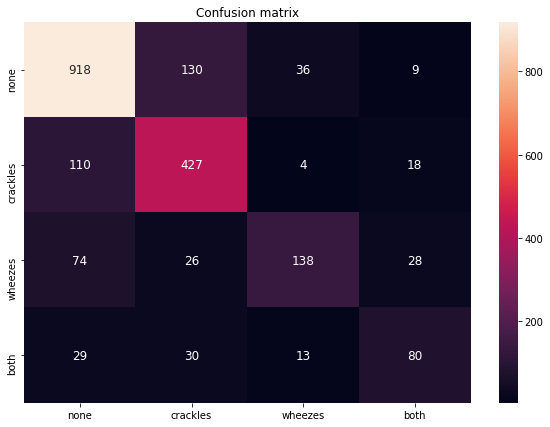

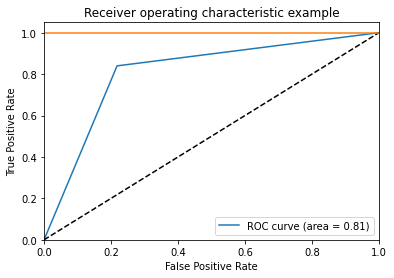

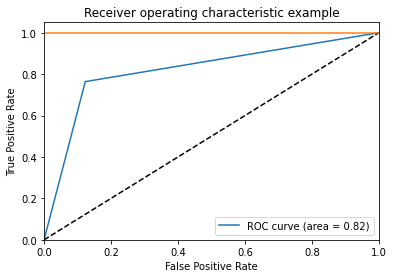

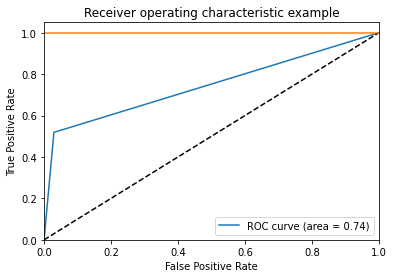

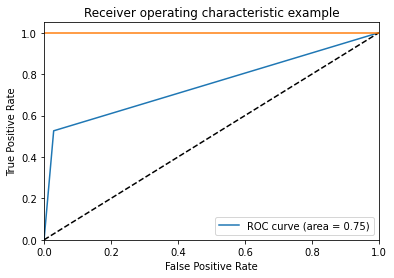

In [16]:
cm(y_test,y_pred)
plot_roc(y_test,y_pred)